# Exercise Set 3

Due: **10:00 3 May 2021**

Discussion: **12:00 7 May 2021**

**Online submission** at via [ILIAS](https://www.ilias.uni-koeln.de/ilias/goto_uk_exc_3952817.html) in the directory Exercises / Übungen -> Submission of Exercises / Rückgabe des Übungsblätter

## 

# 1. Averaging spectral radio data (DATA EXERCISE) [30 Points]

In this exercise you will work on a data set of artificial radio observation `radio-map.fits`. It is a map of 5x5
spectra with 201 measured frequency/velocity channels (channel width is unity). If you number all spectra
from 1 to 25 we use the following scheme to assign spectra to positions on the map (spectrum 1 is the top
left spectrum):

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pprint

In [2]:
m = fits.open("../../exercise_3/radio-mapfits.sec")
pprint.pprint(m[0].header)
spectra = m[0].data

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  201 / length of data axis 1                          
NAXIS2  =                    5 / length of data axis 2                          
NAXIS3  =                    5 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                   0. / scaling offset                                 
BSCALE  =                   1. / scaling offset                                 
AUTHOR  = 'Created with the Wolfram Language : www.wolfram.com' / Software      
DATE    = '2018-04-20T09:11:

**a.** Compute the total “integrated-intensity” map of the observations, i.e. integrate the spectra over the full spectral range for all positions and plot the 5x5 map in a suitable way. **5 Points**

### Solution

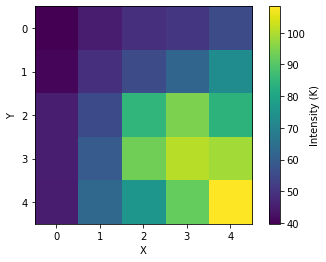

In [3]:
integrated_intensities = np.zeros((5,5))
for x in list(range(5)):
    for y in list(range(5)):
        spectrum = m[0].data[x,y,:]
        integrated_intensities[x,y] = np.sum(spectrum)

fig,ax = plt.subplots()
cm = ax.imshow(integrated_intensities)
cb = fig.colorbar(cm).set_label('Intensity (K)') #these units are not in the FITS header
ax.set_xlabel('X')
ax.set_ylabel('Y');

## 

**b.** Compute two channel maps by integrating over the frequency channels 50-100 and 100-150. Compare the two maps. **5 Points**

### Solution

In [4]:
chan_1 = np.sum(m[0].data[:,:,50:100], axis=2)
chan_2 = np.sum(m[0].data[:,:,100:150], axis=2)

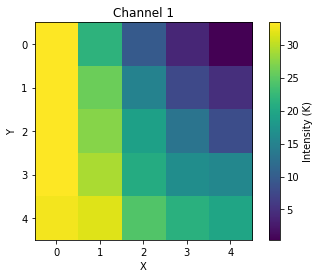

In [5]:
fig,ax = plt.subplots()
cm = ax.imshow(chan_1)
cb = fig.colorbar(cm).set_label('Intensity (K)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Channel 1');

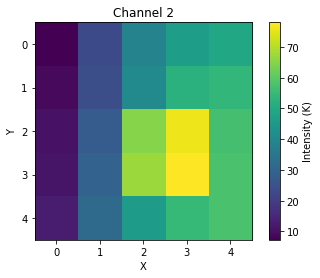

In [6]:
fig,ax = plt.subplots()
cm = ax.imshow(chan_2)
fig.colorbar(cm).set_label('Intensity (K)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Channel 2');

## 

**c.** Compute the average spectrum, by averaging all 25 positions. **5 Points**

### Solution

(5, 5, 201)


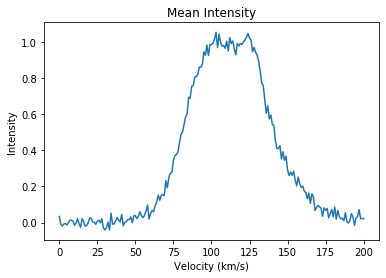

In [7]:
print(np.shape(spectra)) #to see how we should reshape the matrix
spectra_modified = np.reshape(spectra, (25, 201))
mean_spectrum = np.mean(spectra_modified, axis=0)
fig,ax = plt.subplots()
ax.plot(mean_spectrum)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Intensity')
ax.set_title('Mean Intensity');

## 

**d.** Plot every spectrum and overlay the average spectrum. Describe how the emission changes across the map. In particular how the line center position, the peak height and the line widths behave. **15 Points**

### Solution

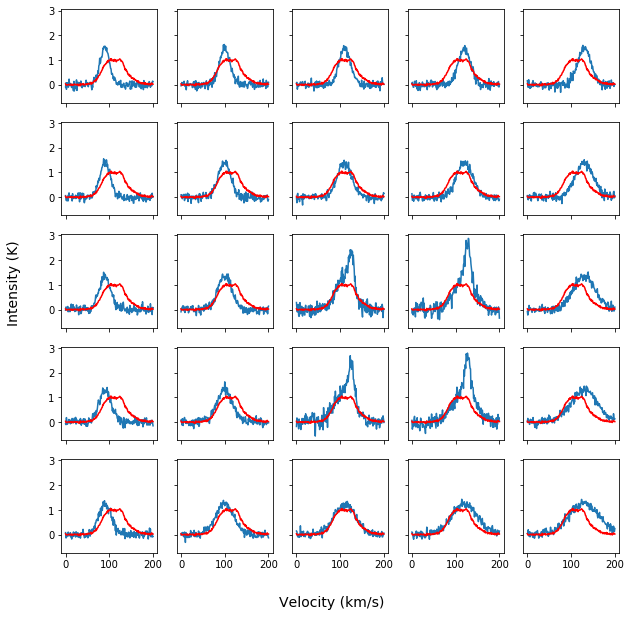

In [8]:
figure = plt.figure(figsize=(10, 10))
axarr = figure.subplots(5, 5, sharex=True, sharey=True)

for x in list(range(5)):
    for y in list(range(5)):
        spectrum = m[0].data[x,y,:]
        ax = axarr[x,y]
        ax.plot(spectrum)
        ax.plot(mean_spectrum, color="red")
        
figure.text(0.5, 0.05, 'Velocity (km/s)', ha='center', fontsize=14)
figure.text(0.05, 0.5, 'Intensity (K)', va='center', rotation='vertical', fontsize=14);

## 

# 2. Dice probability experiment [25 points]

This is an experiment using dice that you can program yourself to test. The experiment itself is not difficult, but it might seem a bit unexpected. Write a function (or a class if you find it easier) to run the experiment for `n` dice:

 1. Each die is rolled and they are arranged in a line.
 2. Begin with the first die. If the value is $v$, continue to the die $v$ places after.
 3. If $v$ is now the value of that die, continue to the die $v$ places after, and so on until you run out of dice.
 4. Discard any additional dice.
 5. Reroll the first die and repeat steps **2** and **3**.

For sufficiently large $n$, step **3** will end on the last die most of the time.

 > example for $n=25$:
 >
 > **5**, 4, 5, 4, 1, **5**, 1, 4, 1, 4, **5**, 6, 5, 1, 6, **3**, 5, 4, **2**, 6, **5**, ~~4, 6, 3, 6~~

In the following example, we will use $50$ dice. Keep your code, as example might show up in a different context later in the course.

This example is taken from this [link](https://phylor.github.io/wuerfelschlange/), where it is called Würfelschlange. I provide a class written to perform this experiment below.

In [62]:
import numpy as np
from copy import copy

class Wuerfelschlange():
    '''
    This is a super verbose class to perform the experiment. You will not need all of the methods here, but
    more were written just for fun. What is important to know is how to initialise and instance and
    check if the experiment was successful.
    
    CALL:
    `Wuerfelschlange(N)`, where N is the number of dice in the experiment.
    
    ATTRIBUTES:
    N : the number of dice in the experiment
    dice : the values of the rolled dice
    dice_used : the number of dice after discarding
    pathindeces : the indeces of the dice in the path
    success : a boolean array with respect to the first die values (1, 2, 3, 4, 5, 6) indicating if the arrangement is successful
    
    METHODS:
    checkrun() : returns a boolean value which is True if the experiment is successful
    reroll() : rerolls the first die and states whether the experiment is successful
    rerun_experiment() : rerolls all N dice, repeating the experiment
    print_dice() : prints the current dice layout, with the dice path in bold and the discarded dice crossed out
    '''
    
    def __init__(self, N):
        
        self.N = N
        self.dice = np.random.randint(1, 6, size=self.N)
        self.dice_used = N
        self.pathindeces = []
        self.success = np.array([False]*6)
        
        self.__baserun()
        self.__checkruns()
        
        return
    
    
    def __baserun(self):
        
        i = 0
        
        while(i < self.dice_used):
            
            self.pathindeces.append(copy(i))
            
            if (i+self.dice[i]) >= self.dice_used:
                self.dice_used = copy(i+1)
                
            i += self.dice[i]
            
        return
    
    
    def __checkruns(self):
        
        # Save a copy of the dice and initialise boolean array
        dice = self.dice.copy()
        success = []
        
        for n in [1, 2, 3, 4, 5, 6]:
            
            i = 0
            dice[0] = n
            indeces = []
            
            # Check dice path
            while(i < self.dice_used-1):
                indeces.append(copy(i))
                i += dice[i]
            
            # Save
            if i == self.pathindeces[-1]:
                success.append(True)
            else:
                success.append(False)
                
        # Save the results
        self.success = np.asarray(success)
        
        return
    
    def checkrun(self):
        
        pathindeces = []
        i = 0
        
        while(i < self.dice_used):
            
            pathindeces.append(copy(i))
            i += self.dice[i]
        
        success = pathindeces[-1] == self.pathindeces[-1]
        self.pathindeces = pathindeces
        
        return success
    
    
    def reroll(self):
        self.dice[0] = np.random.randint(1, 6)
        success = self.checkrun()
        if success:
            print('The reroll was successful.')
        else:
            print('The reroll was unsuccessful.')
        self.print_dice()
        return
    
    
    def rerun_experiment(self):
        
        self.dice = np.random.randint(1, 6, size=self.N)
        self.dice_used = self.N
        self.__baserun()
        self.__checkruns()
        
        return
    
    
    def print_dice(self):
        
        # Initialise the values that will be printed
        values = []
        
        # Loop through the values to add formatting
        for i in range(self.N):
                
            # Bold the values in the path
            if i in self.pathindeces:
                values.append('\033[1m{}\033[0m '.format(self.dice[i]))
            # Stikeout the values dicarded (this should always be less than 6)
            elif i >= self.dice_used:
                values.append('\u0336{} '.format(self.dice[i]))
            # Standard formatting for the other values
            else:
                values.append('{} '.format(self.dice[i]))
            
            # Create a new line every 25 values
            if ((i+1) % 25) == 0:
                values.append('\n')
        
        print(''.join(values))
        
        return

In [84]:
run = Wuerfelschlange(30)

In [85]:
run.print_dice()

5 1 5 4 5 3 5 5 2 5 1 5 5 4 3 2 4 5 3 2 4 1 2 1 5 
1 4 2 2 2 


In [101]:
run.rerun_experiment()
run.success

array([ True,  True,  True,  True,  True,  True])

**a.** What is the expectation value of one die? **5 points**

### Solution

Each value on the die is equally probable, with a probability of $\frac{1}{6}$. The expectation value of one roll of the die, X, is thus given from,

$$
\mathcal{E}(X) = \Sigma^6_{n=1} n p_n \\
\mathcal{E}(X) = \frac{21}{6} \\
\mathcal{E}(X) = 3.5.
$$

## 

**b.** For a given run of the experiment (i.e. for one roll of the first die), we can refer to the dice used as our *path*. What is our expected pathlength in number of dice? **5 points**

### Solution

Using the expected value for each roll of the die, we can simply calculate the pathlength, $p$, as,

$$
p = \frac{N}{\mathcal{E}(X)} \approx 14.
$$

## 

**c.** The initial path is the base that makes this experiment work, and any subsequent path might deviate slightly but will converge on the initial path. What is the probability that an arbitrary path is completely different than the initial path (and thus making this experiment fail)? **5 points**

### Solution

We are looking for the path that does not converge with the original layout. We can look at the maximum probability, which occurs when we assume the dice in the path each have the maximum die value (6). Thus in six consecutive dice, we need one of the dice from the first layout to be different in order for the experiment to fail. For this we can use the probability each of the dice are different: $P(\mathrm{not} \ p) = \frac{5}{6}$. This is applied to each of the dice in the pathlength.

$$
P(fail) = P(\mathrm{not} \ p)^p = \left( \frac{5}{6} \right)^{14} \approx 0.078.
$$

It might seem a bit strange that we use the maximum die value for each of the dice in the path length (as done in the [explanation](http://docplayer.org/21039917-Was-fuer-ein-zufall-mathematischer-hintergrund-einiger-exponate.html) of the statistics) since we previously calculated the expectation value of each die roll and used this to calculate the path length. Indeed, what we just calculated is a maximum limit for the experiment to fail. A more-accurate estimate of $P(fail)$ is calculated assuming 1 of every expected step size is different from the original layout.

$$
P(fail) = \left( \frac{2}{3} \right)^{14} \approx 0.0034.
$$

## 

**d.** Perform this experiment 100 times. Does the fraction of failed tests agree with your prediction? What about for 1000 tests? 10000? **10 points**

### Solution

The class provided will run the experiment once for the given number of dice, N. We can use the method `rerun_experiment` to perform the experiment again for the same number of dice. A check if the experiment is successful can be performed using the `success` method, which returns a boolean value. Thus we just need to run these lines in a loop to get a sense of how often this experiment is successful.

In [110]:
N = 50
n_runs = 50000
experiments = []

for _ in range(n_runs):
    run = Wuerfelschlange(N)
    experiments.append(run.success.all())

experiments = np.asarray(experiments)
f_fail = experiments[~experiments].size/n_runs
print('The fraction of experiments that fail in {} experiments is {:.8f}'.format(n_runs, f_fail))

The fraction of experiments that fail in 50000 experiments is 0.00460000


## 

# 3. Efficient choosing [15 Points]

Imagine you are on a ten-night observing run with a colleague, in settled weather. You have an agreement
that one of the nights, of your choosing, will be for your exclusive use.

**a.** Show that, if you wait for the first five nights and then choose the first night in the next five that is better any of the first, you have a 25 per cent chance of getting the best night of the ten. **5 Points**

### Solution

For a simple strategy, divide te set of nights into equal parts: a "training" set of the first five nights, and a "target set" of the second half. Pick the first night in the second half that is better than any of the nights in the first half. To get the best night of the ten, we need the best night to be in the second half (probability 1/2). If the second-best night is in the first half (probability 1/2) we will definitely pick the best one, so the chance of doing so is 1/4. 

## 

**b.** Show that the optimum length of the "training sample" is a fraction $\frac{1}{e}$ of the total. This can be done analytically or numerically. Please use a numerical approach (ie. perform the *experiment* multiple times to constrain the optimal training sample). **10 Points**

### Solution

In [13]:
import math
import numpy as np
def probablity_of_choosing_best_night(n, N, throws=10000):
#    fraction = n / N
#    start_count = math.floor(fraction)
#    print(fraction)
    best = []
    for i in range(throws):
        a = np.random.choice(range(1, N+1), N, replace = False)
        amax = max(a[:n]) #taking maximum of first five values
        j = n
        while j < N:
            if a[j] > amax:
                best.append(a[j])
                j=N
            j += 1
            if j==N:
                best.append(None)
    return best.count(N)/throws*100

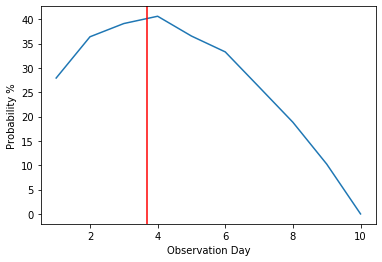

In [14]:
N = 10
x = []
y = []
for i in range(1,N+1):
    x.append(i)
    y.append(probablity_of_choosing_best_night(i, N, throws=10000))
    
fig,ax = plt.subplots()
ax.plot(x, y)

fraction = N/2.71
ax.axvline(fraction, color="red")

ax.set_xlabel('Observation Day')
ax.set_ylabel('Probability %');

In [15]:
best = []
for i in range(10000):
    a = np.random.choice(range(1, 11), 10, replace = False)
    amax = max(a[:5]) #taking maximum of first five values
    j = 5
    while j < 10:
        if a[j] > amax:
            best.append(a[j])
            j=10
        j += 1
        if j==10:
            best.append(None)

In [16]:
number_of_nights = 10
training_sample_lenght = 3

fraction = training_sample_lenght/number_of_nights

print(fraction)




0.3


## 

# 4. Bayesian inference - conditional probabilities [20 Points]

Consider the proverbial bad penny, for which prior information has indicated that there is a probability of $P_r(B)=99$
that it is unbiased ("ok"); or a probability of $P(B)=0.01$ that it is double-headed ("dh").

**a.** Draw a tree diagram and label and label the nodes with the corresponding events and the vertices with the corresponding probabilities. **5 Points**

### Solution

To make the following code work install ipython-tikzmagic as explained here: https://github.com/mkrphys/ipython-tikzmagic

Please note that these cells do not currently work on JupyterHub, but you may download this package on your own machine to use them.

In [2]:
%load_ext tikzmagic

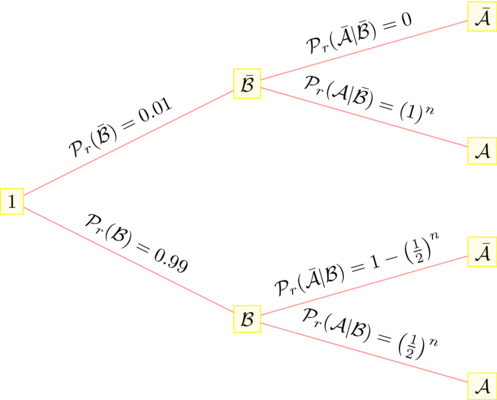

In [8]:
%%tikz -f png -sc 1.2 -s 800,400 -l trees -po grow=right,sloped -S treeDiagram.png

\tikzstyle{level 1}=[level distance=3.5cm, sibling distance=3.5cm]
\tikzstyle{level 2}=[level distance=3.5cm, sibling distance=2cm]
\tikzstyle{bag} = [rectangle, draw=yellow, fill=yellow!10,]
\tikzstyle{end} = [circle, minimum width=3pt,fill, inner sep=0pt]

\node[bag] {1}
    child {
        node[bag] {$\mathcal{B}$}        
            child {
                node[bag] {$\mathcal{A}$}
                edge from parent [color=red!50]
                node[above, color=black] {$\mathcal{P}_r(\mathcal{A}|\mathcal{B})=\left(\frac{1}{2}\right)^n$}
            }
            child {
                node[bag] {$\bar\mathcal{A}$}
                edge from parent [color=red!50]
                node[above, color=black] {$\mathcal{P}_r(\bar\mathcal{A}|\mathcal{B})=1-\left(\frac{1}{2}\right)^n$}
            }
            edge from parent  [color=red!50]
            node[above, color=black] {$\mathcal{P}_r(\mathcal{B})=0.99$}
    }
    child {
        node[bag] {$\bar\mathcal{B}$}        
            child {
                node[bag] {$\mathcal{A}$}
                edge from parent [color=red!50]
                node[above, color=black] {$\mathcal{P}_r(\mathcal{A}|\bar\mathcal{B})=\left(1\right)^n$}
            }
            child {
                node[bag] {$\bar\mathcal{A}$}
                edge from parent [color=red!50]
                node[above, color=black] {$\mathcal{P}_r(\bar\mathcal{A}|\bar\mathcal{B})=0$}
            }
            edge from parent  [color=red!50]
            node[above, color=black] {$\mathcal{P}_r(\bar\mathcal{B})=0.01$}
    };

Alternatively use `![title](./treeDiagram.png)` or `<img src="treeDiagram.png" title="title" />` in a Markdown cell to show the image.

## 

**b.** Suppose that the coin is fair, what is the probability P(A|B) of obtaining n heads in a row? **5 Points**

### Solution

$\mathcal{P}_r$(n heads in a row | coin is fair) = $p^n$ with $p=1/2$

$\left(\frac{1}{2}\right)^n$

## 

**c.** Now suppose, the coins is unfair, i.e. double-headed, what is the probability $P(A|B)$ of obtaining n heads in a row in this case? **5 Points**

### Solution

$\mathcal{P}_r$(n heads in a row | coin is double-headed) = $p^n$ with $p=1$

$(1)^n=1$

## 

**d.** Give the probability $P(A)=P($n heads in a row$)$ given our initial priors. **5 Points**

### Solution

$\mathcal{P}_r(\mathcal{A})$(n heads in a row) = $\mathcal{P}_r$(n heads | coin is fair)*$\mathcal{P}_r$(coin is fair) +$\mathcal{P}_r$(n heads | coin is double-headed) * $\mathcal{P}_r$(coin is double-headed)

$\left(\frac{1}{2}\right)^n$ 0.99 + $1^n$ 0.01

## 

**e.** Give the (Bayesian) posterior probability $P(B|A)$ of obtaining n heads in a row. **5 Points**

### Solution

$\mathcal{P}_r(\mathcal{B}|\mathcal{A}) = \frac{\mathcal{P}_r(\mathcal{A}|\mathcal{B})*\mathcal{P}_r(\mathcal{B})}{\mathcal{P}_r(\mathcal{A})}$ =

$\left(\frac{1}{2}\right)^n * 0.99 / \left(\left(\frac{1}{2}\right)^n * 0.99 + 1^n * 0.01\right)$

## 

**f.** What are the odds on the penny being fair, i.e. what is the (Bayesian) posterior probability $P(B|A)$ given this information, if we obtain 2 heads in a row? What is the probability if we obtain 7 heads in a row? In the last case (7 heads) how might we consider the fairness of the coin? Or of the experimenter who provided us with the prior information? **5 Points**

### Solution

In [22]:
def probability(n):
    p = 0.5**n * 0.99
    p = p / (0.5**n * 0.99 + 1**n * 0.01)
    return p

for n in [2,7]:
    print("For {} heads in a row the probability is: {:1.0f} %".format(n, probability(n)*100))


For 2 heads in a row the probability is: 96 %
For 7 heads in a row the probability is: 44 %


On the one hand we have clearly made us of prior information in a formal way. On the other hand, would we retain this information? What might our judgement be of the experiment or  the person providing us with this information?

For the most part even the strongest proponents of Bayesian methods recognize that when the *a posteriori* results are strongly sensitive to the priors, acquistion of more data really should take priority over debating the choice of these riors.